# **Transfer Learning** in computer vision

Transfer learning is a technique in deep learning where a pre-trained model is fine-tuned for a different but related task.

1. **Efficiency**: Transfer learning is efficient because it allows you to leverage the knowledge from a model trained on a large dataset without having to train a model from scratch, which can be time-consuming and require a lot of data.
2. **Feature Extraction**: Convolutional Neural Networks (CNNs) learn to extract features from images. By using transfer learning, you can leverage features extracted by large models trained on more diverse datasets, possibly including features not present in your smaller dataset.
3. **Community and Sharing**: The AI community often shares pre-trained models openly. This sharing culture is a driving force in AI advancements as it allows researchers and developers who might not have access to huge computational resources to still utilize advanced models.
4. **Application in TensorFlow**: TensorFlow makes transfer learning easy to implement. You can download a pre-trained model, freeze the weights in the early layers (to retain the extracted features), and train the later layers on your specific dataset.
5. **Inception Model**: One of the pre-trained models often used for transfer learning is the Inception model. It is a deep CNN that has been trained on over a million images and can classify images into 1000 object categories.
6. **Practical Implementation**: In practice, you can use transfer learning by taking a pre-trained model like Inception, lock or freeze the layers up to a certain point, append a deep neural network (DNN) to the model, and train the DNN and the latter part of the model on your specific dataset.
7. **Benefits**: Using transfer learning can lead to faster training times and often higher accuracy compared to training a model from scratch, especially if you have a limited amount of training data.
8. **Contribution to the Open Community**: The conversation encourages learners and developers to contribute back to the open community by sharing their work, following the example set by many in the AI community.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

## Setup the pretrained model

You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model. To do that, you need to:

1. Set the input shape to fit your application. In this case. set it to `150x150x3` as you've been doing in the last few labs.

2. Pick and freeze the convolution layers to take advantage of the features it has learned already.

3. Add dense layers which you will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, you want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because you will be replacing it later. You will also specify the input shape that your model will accept. Lastly, you want to freeze the weights of these layers because they have been trained already.

In [6]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-30 10:00:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

./inception_v3_weig 100%[===================>]  83.84M  25.2MB/s    in 3.5s    

2023-06-30 10:00:24 (23.9 MB/s) - ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence showed in the exercise, you will use up to `mixed_7` as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed_7` on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [8]:
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [9]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Add dense layers for your classifier

Next, you will add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer as well to regularize the output and avoid overfitting.

In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                              

In [11]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Prepare the dataset

Now you will prepare the dataset. This is basically the same code as the one you used in the data augmentation lab.

In [16]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Assign training and validation set directories
base_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

--2023-06-30 10:17:26--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M  29.9MB/s    in 2.2s    

2023-06-30 10:17:28 (29.9 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train the model

With that, you can now train the model. You will do 20 epochs and plot the results afterwards.

In [17]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 36s 238ms/step - loss: 0.3544 - accuracy: 0.8570 - val_loss: 0.0905 - val_accuracy: 0.9600
Epoch 2/20
100/100 [==============================] - 23s 232ms/step - loss: 0.2047 - accuracy: 0.9170 - val_loss: 0.0938 - val_accuracy: 0.9610
Epoch 3/20
100/100 [==============================] - 23s 233ms/step - loss: 0.2012 - accuracy: 0.9210 - val_loss: 0.0851 - val_accuracy: 0.9620
Epoch 4/20
100/100 [==============================] - 22s 216ms/step - loss: 0.1621 - accuracy: 0.9335 - val_loss: 0.1015 - val_accuracy: 0.9590
Epoch 5/20
100/100 [==============================] - 23s 225ms/step - loss: 0.1818 - accuracy: 0.9360 - val_loss: 0.0893 - val_accuracy: 0.9600
Epoch 6/20
100/100 [==============================] - 23s 226ms/step - loss: 0.1568 - accuracy: 0.9355 - val_loss: 0.0924 - val_accuracy: 0.9690
Epoch 7/20
100/100 [==============================] - 23s 230ms/step - loss: 0.1552 - accuracy: 0.9385 - val_loss: 0.0973 - val_ac

## Evaluate the results

You will use the same code to plot the results. As you can see, the validation accuracy is also trending upwards as your training accuracy improves. This is a good sign that your model is no longer overfitting!

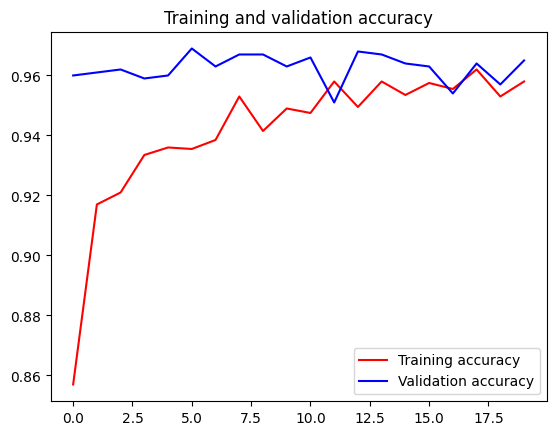

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()